In [69]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

# Task 1. House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [70]:
folder=''

In [71]:
REsample=pd.read_csv(folder+'data/NYChome_sales2012.csv',index_col=0)

In [72]:
len(REsample)

14611

In [73]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [74]:

REsample.columns

Index(['borough', 'neighborhood', 'block', 'lot', 'easement',
       'building_class_present', 'address', 'zip_code', 'commmercial_units',
       'land_sq_feet', 'gross_sq_feet', 'year_built', 'sale_price',
       'sale_date'],
      dtype='object')

In [75]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444], dtype=int64)

In [76]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample))
REsample1=REsample.loc[splitind<=0.4]
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)]
REsample3=REsample.loc[(splitind>=0.7)]

In [77]:
len(REsample1) #loosing around 50 records within sparse zip codes

5832

In [78]:
len(REsample2)

4394

In [79]:
len(REsample3)

4385

In [80]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [81]:
data311 = pd.read_csv( folder+'data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [82]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce')

In [83]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [84]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [85]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,...,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,...,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,...,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,...,1,1,0,16,21,0,0,37,0,0


In [86]:
list_311=list(data311.columns)

In [87]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various cathegories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity

In [88]:
len(data311) #only 179 zip codes with reliable data left

179

In [89]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,...,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,...,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,...,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.0,0.0
10004.0,0.000000,0.000000,0.009740,0.0,0.000000,0.002597,0.001948,0.000649,0.000000,0.000649,...,0.000649,0.000649,0.000000,0.010390,0.013636,0.000000,0.000000,0.024026,0.0,0.0


#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

In [90]:
lm = smf.ols(formula = 'sale_price ~ gross_sq_feet+land_sq_feet+year_built', data = REsample1).fit()

#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [91]:
dictionary = {}
for i, c in enumerate(data311.columns):
    F_curr = 'F'+ str(i+1)
    data311.rename(columns={c:F_curr},inplace=True)
    dictionary[F_curr] = c

In [92]:
REsample1_311 = pd.merge(REsample1, data311, left_on='zip_code', right_on=data311.index)
REsample2_311 = pd.merge(REsample2, data311, left_on='zip_code', right_on=data311.index)
REsample3_311 = pd.merge(REsample3, data311, left_on='zip_code', right_on=data311.index)

In [93]:
help(pd.merge)

Help on function merge in module pandas.core.reshape.merge:

merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
    Merge DataFrame or named Series objects with a database-style join.
    
    The join is done on columns or indexes. If joining columns on
    columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
    on indexes or indexes on a column or columns, the index will be passed on.
    
    Parameters
    ----------
    left : DataFrame
    right : DataFrame or named Series
        Object to merge with.
    how : {'left', 'right', 'outer', 'inner'}, default 'inner'
        Type of merge to be performed.
    
        * left: use only keys from left frame, similar to a SQL left outer join;
          preserve key order.
        * right: use only keys from right frame, similar to a SQL right outer join;
          preserve key 

#### Q3. Run the linear model with 311
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [94]:
formula = 'sale_price ~ gross_sq_feet+land_sq_feet+year_built+F'+'+F'.join([str(p) for p in range(1,len(dictionary)+1)])
formula

'sale_price ~ gross_sq_feet+land_sq_feet+year_built+F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21+F22+F23+F24+F25+F26+F27+F28+F29+F30+F31+F32+F33+F34+F35+F36+F37+F38+F39+F40+F41+F42+F43+F44+F45+F46+F47+F48+F49+F50+F51+F52+F53+F54+F55+F56+F57+F58+F59+F60+F61+F62+F63+F64+F65+F66+F67+F68+F69+F70+F71+F72+F73+F74+F75+F76+F77+F78+F79+F80+F81+F82+F83+F84+F85+F86+F87+F88+F89+F90+F91+F92+F93+F94+F95+F96+F97+F98+F99+F100+F101+F102+F103+F104+F105+F106+F107+F108+F109+F110+F111+F112+F113+F114+F115+F116+F117+F118+F119+F120+F121+F122+F123+F124+F125+F126+F127+F128+F129+F130+F131+F132+F133+F134+F135+F136+F137+F138+F139+F140+F141+F142+F143+F144+F145+F146+F147+F148+F149+F150+F151+F152+F153+F154+F155+F156+F157+F158+F159+F160+F161+F162'

In [95]:
lm2 = smf.ols(formula = formula, data = REsample1_311).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     30.23
Date:                Mon, 18 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:01:27   Log-Likelihood:                -85271.
No. Observations:                5710   AIC:                         1.708e+05
Df Residuals:                    5560   BIC:                         1.718e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.873e+08    6.1e+07     -3.071

In [96]:
r2_train = r2_score(REsample1_311.sale_price,lm2.predict(REsample1_311))
r2_test = r2_score(REsample3_311.sale_price,lm2.predict(REsample3_311))
print('The training R2 is: {}'.format(r2_train))
print('The test R2 is: {}'.format(r2_test))

The training R2 is: 0.44755585866664527
The test R2 is: 0.2788057468106786


#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [97]:
columns = []
for i in dictionary:
    columns.append(i)
#Extract the features we are going to use
columns.append('gross_sq_feet')
columns.append('land_sq_feet')
columns.append('year_built')

In [98]:
mu=REsample1_311[columns].mean()
sigma=REsample1_311[columns].std()

In [123]:
Scaled1_311=(REsample1_311[columns]-mu)/sigma
Scaled2_311=(REsample2_311[columns]-mu)/sigma
Scaled3_311=(REsample3_311[columns]-mu)/sigma

In [128]:
Scaled1_311 = Scaled1_311.dropna(axis=1,how='any')
Scaled2_311 = Scaled2_311.dropna(axis=1,how='any')
Scaled3_311 = Scaled3_311.dropna(axis=1,how='any')

In [129]:
print(np.any(np.isnan(Scaled1_311)))
print(np.all(np.isfinite(Scaled1_311)))

False
True


In [126]:
Scaled1_311

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F156,F157,F158,F159,F160,F161,F162,gross_sq_feet,land_sq_feet,year_built
0,3.536481,-0.33729,-0.349858,2.023700,-0.484463,-0.288680,-1.027910,-0.246486,-0.599716,-0.300726,...,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687,-0.363210,-0.511639,-1.670001
1,3.536481,-0.33729,-0.349858,2.023700,-0.484463,-0.288680,-1.027910,-0.246486,-0.599716,-0.300726,...,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687,0.250513,0.027231,-1.593465
2,3.536481,-0.33729,-0.349858,2.023700,-0.484463,-0.288680,-1.027910,-0.246486,-0.599716,-0.300726,...,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687,-0.156854,-0.377085,-1.249051
3,3.536481,-0.33729,-0.349858,2.023700,-0.484463,-0.288680,-1.027910,-0.246486,-0.599716,-0.300726,...,-0.453754,-0.174600,-0.719157,-1.423825,-0.937235,-0.278540,-0.208687,0.065541,-0.377085,-1.440392
4,1.569431,-0.33729,-0.401531,3.711176,0.104541,-0.408331,0.379982,0.276196,-0.599716,-0.300726,...,-0.589710,-0.453153,-0.082645,-0.750009,-0.155079,1.146794,-0.208687,0.052710,-0.594794,0.090336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,-1.017304,5.69253,0.169526,-0.239723,6.448176,-0.671732,0.203779,-0.833108,1.703905,-0.300726,...,-0.352911,-0.527248,0.890945,-0.012120,0.658919,-0.278540,-0.208687,-0.983348,0.165386,-0.866369
5706,-1.017304,5.69253,0.169526,-0.239723,6.448176,-0.671732,0.203779,-0.833108,1.703905,-0.300726,...,-0.352911,-0.527248,0.890945,-0.012120,0.658919,-0.278540,-0.208687,0.562720,-0.278871,2.042014
5707,-1.017304,5.69253,0.169526,-0.239723,6.448176,-0.671732,0.203779,-0.833108,1.703905,-0.300726,...,-0.352911,-0.527248,0.890945,-0.012120,0.658919,-0.278540,-0.208687,-0.482961,0.141815,-1.593465
5708,-1.017304,5.69253,0.169526,-0.239723,6.448176,-0.671732,0.203779,-0.833108,1.703905,-0.300726,...,-0.352911,-0.527248,0.890945,-0.012120,0.658919,-0.278540,-0.208687,-0.346103,0.580506,-1.440392


In [30]:
#X_scale = preprocessing.scale(REsample1_311[columns])
#X_scale_valid = preprocessing.scale(REsample2_311[columns])
#X_scale_test = preprocessing.scale(REsample3_311[columns])
# Scale the features in all three samples

In [127]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1).fit(Scaled1_311, REsample1_311['sale_price'])

In [130]:
r2_train = r2_score(REsample1_311.sale_price,Ridge.predict(Scaled1_311))
r2_test = r2_score(REsample3_311.sale_price,Ridge.predict(Scaled3_311))
print('The Ridge training R2 is: {}'.format(r2_train))
print('The Ridge out-of-sample R2 is: {}'.format(r2_test))

The Ridge training R2 is: 0.44741272142935196
The Ridge out-of-sample R2 is: 0.2794473888029133


In [131]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1).fit(Scaled1_311, REsample1_311['sale_price'])

In [133]:
r2_train = r2_score(REsample1_311.sale_price,Lasso.predict(Scaled1_311))
r2_test = r2_score(REsample3_311.sale_price,Lasso.predict(Scaled3_311))
print('The Lasso training R2 is: {}'.format(r2_train))
print('The Lasso out-of-sample R2 is: {}'.format(r2_test))

The Lasso training R2 is: 0.44708565171129644
The Lasso out-of-sample R2 is: 0.2739233665343517


In [35]:
# This is because we haven't tune the hyperparameters so the performancs look bad. 

#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [36]:
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

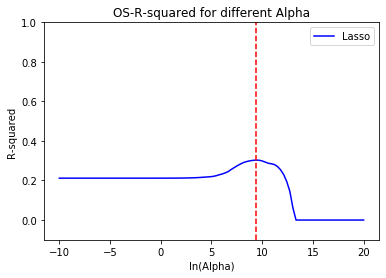

Optimal alpha for Lasso=12015.339377705404, best OS R_2=0.3032249454510386


array([     0.        ,     -0.        ,      0.        ,     -0.        ,
            0.        , -31524.9303307 , -13573.22996516,      0.        ,
           -0.        ,  51258.75812469,     -0.        ,     -0.        ,
            0.        ,   4406.80280829,      0.        ,  66505.16034734,
           -0.        ,  32398.55351521,     -0.        ,      0.        ,
        -8476.27935265,  -4232.54634622,  10358.01806462,  13747.00748937,
            0.        ,     -0.        , -18653.1556221 ,     -0.        ,
       396307.79281935,     -0.        ,      0.        ,     -0.        ,
       -16807.99332919,     -0.        ,     -0.        ,  14553.08222383,
           -0.        ,     -0.        ,      0.        , -86980.27863359,
            0.        ,  -9073.81149679,      0.        ,     -0.        ,
        -4852.62442359,     -0.        ,     -0.        , -47231.814818  ,
           -0.        ,      0.        ,      0.        ,     -0.        ,
           -0.        ,  

In [134]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,Scaled1_311,REsample1_311['sale_price'],Scaled2_311,REsample2_311['sale_price'],alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

In [135]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=12015).fit(Scaled1_311, REsample1_311['sale_price'])
r2_test = r2_score(REsample3_311.sale_price,Lasso.predict(Scaled3_311))
print('The Lasso R2 performance over test set is: {}'.format(r2_test))

The Lasso R2 performance over test set is: 0.36345312673345587


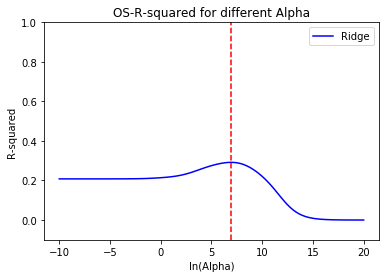

Optimal alpha for Ridge=1063.900307652953, best OS R_2=0.29180436975799307


array([-2.70886468e+03, -3.27258757e+04,  2.79304236e+04, -6.14420025e+03,
        2.41471858e+04, -2.84444930e+04, -2.11305245e+04,  2.49063885e+04,
       -3.26516268e+04,  5.25183009e+04, -1.29848997e+04, -3.85995945e+04,
        7.38147025e+03,  2.19371590e+04, -5.69893776e+02,  8.68984267e+04,
       -5.20890868e+03,  4.50370849e+04, -3.42193715e+03, -1.53242112e+04,
       -2.74721964e+04, -1.28931626e+04,  2.58228901e+04,  1.15782206e+04,
       -1.68173023e+04,  1.56987379e+02, -5.32932470e+04,  1.29677811e+03,
        2.17438925e+05,  1.65667843e+04,  2.36671619e+03, -1.42600770e+04,
       -7.26281584e+04,  2.05656352e+03, -1.33487960e+04,  3.28787549e+04,
       -2.22476749e+04, -1.90634358e+04,  2.02744209e+04, -6.47019881e+04,
        1.63233331e+04, -2.24224924e+04,  9.71072935e+03,  4.27063351e+03,
       -3.04428806e+04, -2.75250921e+04, -4.59957443e+02, -5.45064619e+04,
       -1.16489559e+04, -4.15647712e+03,  2.09767954e+04,  5.91597424e+03,
       -4.50921465e+04,  

In [136]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, Ridge_coefs]=Regularization_fit_alpha(1,Scaled1_311,REsample1_311['sale_price'],Scaled2_311,REsample2_311['sale_price'],alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Ridge_coefs

In [137]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1064).fit(Scaled1_311, REsample1_311['sale_price'])
r2_test = r2_score(REsample3_311.sale_price,Ridge.predict(Scaled3_311))
print('The Ridge R2 performance over test set is: {}'.format(r2_test))

The Ridge R2 performance over test set is: 0.33994257204105227


# Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [138]:
#load the data
dataIncome=pd.read_csv(folder+"data/MeanZip.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [139]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(dataIncome))
dataIncome1=dataIncome.loc[splitind<=0.4]
dataIncome2=dataIncome.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3=dataIncome.loc[(splitind>=0.7)]

#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [152]:
columns = data311.columns

In [153]:
dataIncome1_311 = pd.merge(dataIncome1['Mean'], data311, left_on=dataIncome1.index, right_on=data311.index)
dataIncome2_311 = pd.merge(dataIncome2['Mean'], data311, left_on=dataIncome2.index, right_on=data311.index)
dataIncome3_311 = pd.merge(dataIncome3['Mean'], data311, left_on=dataIncome3.index, right_on=data311.index)

In [154]:
dataIncome1_311 = dataIncome1_311.set_index('key_0')
dataIncome2_311 = dataIncome2_311.set_index('key_0')
dataIncome3_311 = dataIncome3_311.set_index('key_0')

In [156]:
mu=dataIncome1_311[columns].mean()
sigma=dataIncome1_311[columns].std()

In [157]:
Scaled1_311=(dataIncome1_311[columns]-mu)/sigma
Scaled2_311=(dataIncome2_311[columns]-mu)/sigma
Scaled3_311=(dataIncome3_311[columns]-mu)/sigma

In [158]:
Scaled1_311 = Scaled1_311.dropna(axis=1,how='any')
Scaled2_311 = Scaled2_311.dropna(axis=1,how='any')
Scaled3_311 = Scaled3_311.dropna(axis=1,how='any')

In [159]:
print(np.any(np.isnan(Scaled1_311)))
print(np.all(np.isfinite(Scaled1_311)))

False
True


In [45]:
#X_scale = preprocessing.scale(dataIncome1_311[columns])
#X_scale_valid = preprocessing.scale(dataIncome2_311[columns])
#X_scale_test = preprocessing.scale(dataIncome3_311[columns])

In [160]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=100).fit(Scaled1_311, dataIncome1_311['Mean'])
r2_test = r2_score(dataIncome3_311.Mean,Ridge.predict(Scaled3_311))
print('The Ridge R2 performance over test set is: {}'.format(r2_test))

The Ridge R2 performance over test set is: 0.20642956252228017


In [161]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=100).fit(Scaled1_311, dataIncome1_311['Mean'])
r2_test = r2_score(dataIncome3_311.Mean,Lasso.predict(Scaled3_311))
print('The Lasso R2 performance over test set is: {}'.format(r2_test))

The Lasso R2 performance over test set is: -0.7893104421955184


#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

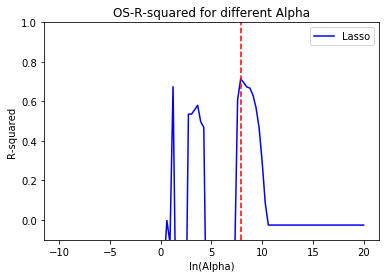

Optimal alpha for Lasso=2640.669807145078, best OS R_2=0.7142663458329066


array([   -0.        ,     0.        ,  4067.87136156,    -0.        ,
           0.        ,     0.        ,     0.        ,    -0.        ,
          -0.        ,    -0.        ,     0.        ,    -0.        ,
           0.        ,     0.        ,    -0.        ,  6054.03937251,
        -396.42977153,     0.        ,     0.        ,     0.        ,
          -0.        ,     0.        , -1828.14054249,    -0.        ,
           0.        ,    -0.        ,     0.        ,  -220.19047942,
       15464.90471583,     0.        ,     0.        ,  3176.73200287,
        1947.99428189,     0.        ,    -0.        ,     0.        ,
           0.        ,    -0.        ,   456.34864406,     0.        ,
        -525.4533753 ,     0.        ,    -0.        ,    -0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
       -2538.58533749,     0.        ,     0.        ,     0.        ,
          -0.        ,     0.        ,    -0.        , -6504.63376017,
      

In [162]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, Lasso_coefs]=Regularization_fit_alpha(2,Scaled1_311, dataIncome1_311['Mean'],Scaled2_311,dataIncome2_311['Mean'],alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Lasso_coefs

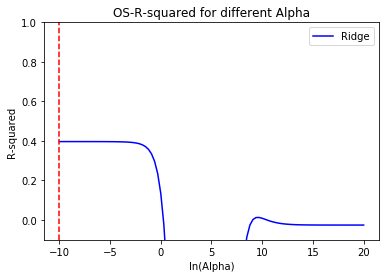

Optimal alpha for Ridge=4.5399929762484854e-05, best OS R_2=0.3968507094645841


array([ 1.56985493e+02,  7.65863605e+02,  5.26363453e+03,  1.50186629e+02,
       -3.32085610e+02,  1.89243947e+03,  1.66072213e+03, -7.84758405e+02,
       -6.66873511e+02, -1.80600411e+03, -2.70978135e+02,  5.88415029e+02,
        3.23968297e+02,  3.17997607e+03, -1.23468346e+01,  3.19868460e+03,
       -2.84077182e+03,  1.28062450e+03,  6.46867535e+02,  1.11683466e+03,
       -2.16882221e+02,  8.48884434e+02, -3.37074815e+03,  1.07950906e+03,
       -7.98440911e+02,  4.01280158e+00,  1.01301660e+03, -1.00211128e+03,
        6.40301210e+03,  3.43142933e+02,  6.94731865e+02,  6.07327862e+02,
        1.25191094e+03, -1.83261689e+03,  8.79873454e+02,  2.73718535e+03,
        1.30481864e+03, -7.53286617e+02,  3.39685913e+03,  7.84885763e+02,
       -1.47383769e+03,  7.56564039e+02, -3.89225196e+00,  3.99654496e+02,
        3.53195035e+03,  1.43247733e+03,  1.54879379e+03,  1.28163983e+03,
       -4.29644928e+03,  1.92037107e+02, -8.08492715e+02,  5.32908042e+02,
       -1.00219876e+03,  

In [163]:
alphas = np.exp(np.linspace(-10,20,100)) #exponential range of possible alphas
[alpha_optimal, best_R2, Ridge_coefs]=Regularization_fit_alpha(1,Scaled1_311, dataIncome1_311['Mean'],Scaled2_311,dataIncome2_311['Mean'],alphas,Graph=True,logl=True)
print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))
Ridge_coefs

In [164]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=4.54).fit(Scaled1_311, dataIncome1_311['Mean'])
r2_test = r2_score(dataIncome3_311.Mean,Ridge.predict(Scaled3_311))
print('The Ridge R2 performance over test set is: {}'.format(r2_test))
Lasso=linear_model.Lasso(fit_intercept=True, alpha=2640).fit(Scaled1_311, dataIncome1_311['Mean'])
r2_test = r2_score(dataIncome3_311.Mean,Lasso.predict(Scaled3_311))
print('The Lasso R2 performance over test set is: {}'.format(r2_test))

The Ridge R2 performance over test set is: -0.2493625292175221
The Lasso R2 performance over test set is: -0.8317432182107123


Try to see if there is multicolinearity in the test set. Not obvious

In [165]:
dataIncome3_311.corr()

,Mean,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F153,F154,F155,F156,F157,F158,F159,F160,F161,F162
Mean,1.000000,-0.601971,-0.048202,0.532607,-0.402385,0.203057,0.372221,0.528405,0.266587,-0.072493,...,0.158221,0.354994,-0.024897,0.352088,0.256317,0.075133,0.043574,0.243078,-0.273994,0.058128
F1,-0.601971,1.000000,-0.014424,-0.348764,0.640300,-0.093160,-0.229923,-0.186470,-0.285597,-0.221451,...,-0.204234,-0.191784,-0.034152,-0.213999,-0.058089,-0.259769,-0.316799,-0.368628,-0.161312,-0.068026
F2,-0.048202,-0.014424,1.000000,-0.048348,-0.001996,-0.052070,0.085858,0.023384,0.086132,0.008608,...,-0.222134,-0.129382,-0.124977,0.022471,0.104192,-0.122258,0.003528,0.205494,-0.070671,-0.060341
F3,0.532607,-0.348764,-0.048348,1.000000,-0.173581,0.017879,0.439399,0.208402,0.175102,0.228383,...,-0.071585,0.682985,-0.204477,0.848331,0.264867,-0.222348,-0.104439,-0.070727,-0.050493,-0.065086
F4,-0.402385,0.640300,-0.001996,-0.173581,1.000000,-0.078410,-0.088951,-0.168331,-0.045686,-0.120690,...,-0.252617,-0.079684,-0.110546,-0.079931,0.006769,-0.153126,-0.278043,-0.121076,-0.000942,-0.086349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F158,0.075133,-0.259769,-0.122258,-0.222348,-0.153126,0.041739,-0.229847,-0.111104,-0.211208,0.024240,...,0.151105,-0.176136,0.537375,-0.163842,-0.257707,1.000000,0.460432,0.506681,-0.100403,0.650785
F159,0.043574,-0.316799,0.003528,-0.104439,-0.278043,0.187256,-0.155010,0.038096,-0.106630,0.233771,...,0.353828,-0.264414,0.098365,-0.201507,-0.193858,0.460432,1.000000,0.273308,-0.038958,0.175668
F160,0.243078,-0.368628,0.205494,-0.070727,-0.121076,0.205257,0.172452,-0.155417,0.160847,-0.003766,...,0.054620,-0.266257,0.455573,-0.060458,-0.156126,0.506681,0.273308,1.000000,-0.237982,0.199642
F161,-0.273994,-0.161312,-0.070671,-0.050493,-0.000942,-0.081549,-0.084796,-0.098855,-0.036418,0.397240,...,-0.111268,-0.118063,-0.122453,-0.048852,0.017273,-0.100403,-0.038958,-0.237982,1.000000,-0.040368


Try to use a different dataset split with more data in train set. The result seems fine

Check the number of samples

In [56]:
len(train)

140

In [57]:
len(test)

35

In [58]:
len(data311)

179

Based on the analysis, I would infer the bad performance is because the number of features is almost equal to that of samples. Lack of smaples leads to inevitable overfitting. Lasso tends to select one feature among all the correlated features, which might leads to instability. Using elastic net might be helpful.